import key libraries from Analysis / TissueGraph. 


In [1]:
from dredFISH.Analysis.TissueGraph import *
from dredFISH.Visualization.Viz import *
from dredFISH.Analysis import Classification
from dredFISH.Utils import basicu
from dredFISH.Utils import geomu
import matplotlib.cm as cm
import numpy as np
basicu.reset_logging(level=logging.WARNING)

2023-02-06 13:20:57,772 [INFO] WRITING LOG OUTPUT TO /home/rwollman/.cellpose/run.log


In [ ]:
inputpath = '/greendata/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/fishdata_2023Feb03/DPNMF_PolyA_2021Nov19'
# or 
inputpath = os.getcwd()

In [2]:

TMG = TissueMultiGraph(inputpath = inputpath,redo = True)
TMG.create_cell_layer(build_spatial_graph = False,build_feature_graph = False)


/home/rwollman/miniconda3/envs/dredFISH/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


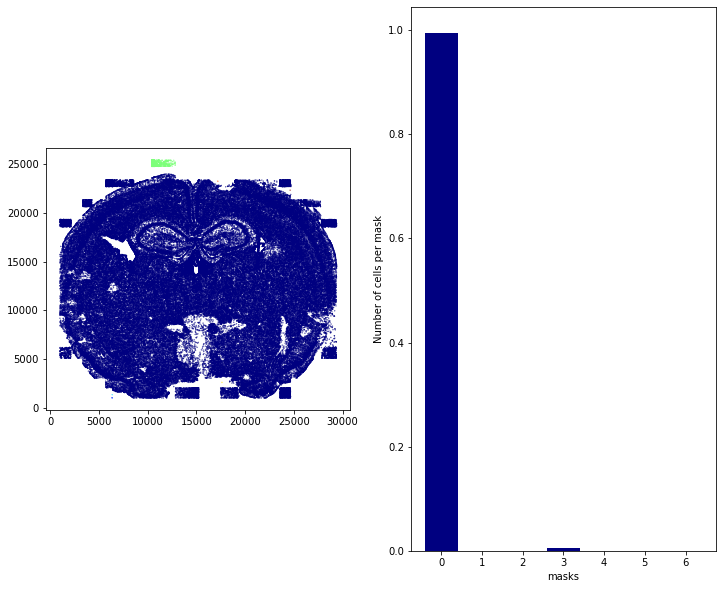

In [3]:
XY = TMG.Layers[0].XY
in_large_comp = geomu.in_graph_large_connected_components(XY,large_comp_def = 0.05,plot_comp = True)


In [4]:
print(f"before filtering: {TMG.N[0]} cells")
TMG.Layers[0].filter(in_large_comp)
print(f"after filtering: {TMG.N[0]} cells")

before filtering: 141657 cells
after filtering: 140861 cells


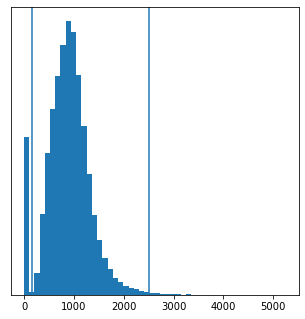

In [5]:
DapiValueDistributions(TMG,min_dapi_line = 150,max_dapi_line=2500,figsize = (4,4)).show()


In [6]:
to_keep = np.logical_and(TMG.Layers[0].adata.obs['dapi']>150,
                         TMG.Layers[0].adata.obs['dapi']<2500) 
print(f"before filtering: {TMG.N[0]} cells")
TMG.Layers[0].filter(to_keep)
print(f"after filtering: {TMG.N[0]} cells")

before filtering: 140861 cells
after filtering: 130870 cells


In [7]:
TMG.Layers[0].build_spatial_graph()

/home/rwollman/MyProjects/MaximallyInformativeBiocartography/dredFISH/dredFISH/Analysis/TissueGraph.py:1162: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.adata.obsp["SG"] = self.SG.get_adjacency_sparse()


Create spatial and features graphs

In [8]:
TMG.Layers[0].build_feature_graph(metric='cosine')

Classify cells 

In [9]:
# Create the classifier
optleiden = Classification.OptimalLeidenUnsupervized(TMG.Layers[0])
# train the classifier
optleiden.train(opt_res=11.5, opt_params={'iters':10, 'n_consensus':1})
# use the classifier to create types and add them to TMG using the Taxonomy created on the fly by the classifier
type_vec = optleiden.classify(TMG.Layers[0].feature_mat)


Number of types: 138 initial entropy: -8.483847782824993 number of evals: 0


/home/rwollman/miniconda3/envs/dredFISH/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [12]:
TMG.add_type_information(0, type_vec, optleiden.tax)
TMG.create_isozone_layer()
logging.info(f"TMG has {len(TMG.Layers)} Layers")

In [13]:
n_topics_list = [2,5,10,15,20,30,50]
n_procs = len(n_topics_list) 

topic_cls = Classification.TopicClassifier(TMG.Layers[0])
topic_cls.train(n_topics_list=n_topics_list, n_procs=n_procs)
topics = topic_cls.classify(topic_cls.Env)

In [14]:
TMG.create_region_layer(topics, topic_cls.tax)
logging.info(f"TMG has {len(TMG.Layers)} Layers")

Add geometries and save

In [15]:
TMG.add_geoms(geom_types = ["mask","voronoi","cell","nuclei","cytoplasm","isozones","regions"])


In [ ]:
TMG.save()